#### Setup

In [1]:
from qiskit_transpiler import get_pm
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB
import qiskit.circuit.library as circuits
from qiskit import QuantumCircuit

In [2]:
#Setting the IBM provider
api_file = "../../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibmq_mumbai')

#### Circuit to only pass as a gate

In [3]:
gate_circuit = QuantumCircuit(2, name='custom_rzx')
gate_circuit.rzx(np.pi/2,0,1)
custom_rzx = gate_circuit.to_gate()

#### Circuit to pass for getting the calibration specific to the qubit

c:\Users\Admin\.conda\envs\simuq\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


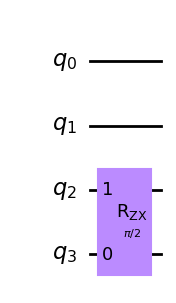

In [4]:
calibration_circuit = QuantumCircuit(4)
calibration_circuit.rzx(np.pi/2,3,2)
calibration_circuit.draw('mpl')

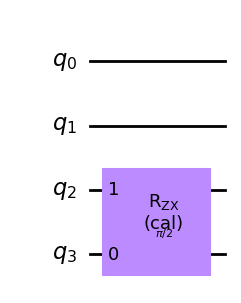

In [5]:
pm = get_pm(backend)
calibrated_circuit = pm.run(calibration_circuit)
calibrated_circuit.draw('mpl')

In [6]:
calibrated_circuit.calibrations

{'rzx': {((3, 2),
   (1.5707963267948966,)): ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24852273944723735, angle=-1.9544697125140549), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=-0.033645972852721674), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.80342292001501, amp=0.16154381850291183, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24852273944723735, angle=1.1871229410757382), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=3.107946

In [7]:
calibration = list(calibrated_circuit.calibrations['rzx'].values())[0]
calibration

ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24852273944723735, angle=-1.9544697125140549), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=-0.033645972852721674), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.80342292001501, amp=0.16154381850291183, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24852273944723735, angle=1.1871229410757382), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=3.1079466807370713), DriveChannel(2)), name="rescale_

In [8]:
backend.target.add_instruction(custom_rzx, {(3,2): InstructionProperties(calibration=calibration)})

In [9]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (3,2) # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rzx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [10]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

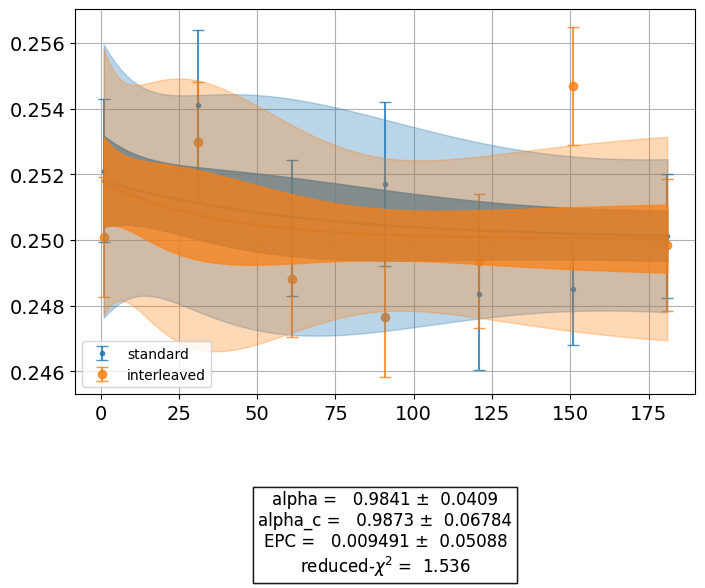

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 113
 - degree of freedom: 10
 - chi-square: 15.355131050466072
 - reduced chi-square: 1.5355131050466073
 - Akaike info crit.: 9.293493025310042
 - Bayesian info crit.: 11.849722343771077
 - init params:
  * a = 0.001105596377841982
  * alpha = 0.9920011356321614
  * b = 0.25
  * alpha_c = 1.0
 - fit params:
  * a = 0.0017878892049423983 ± 0.0016529028688664158
  * alpha = 0.9841005751047677 ± 0.0409030677198439
  * b = 0.2500291317153097 ± 0.0011341434776693884
  * alpha_c = 0.9873447011758539 ± 0.0678388776531205
 - correlations:
  * (alpha, b) = -0.6828129907850626
  * (a, b) = -0.5224846037071577
  * (b, alpha_c) = -0.4193339413060572
  * (alpha, alpha_c) = 0.04884045079434481
  * (a, alpha) = 0.1083945371

In [11]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

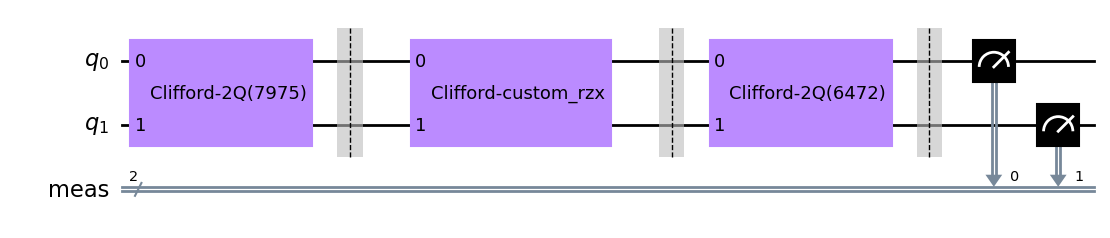

In [12]:
int_exp.circuits()[1].draw(output='mpl')

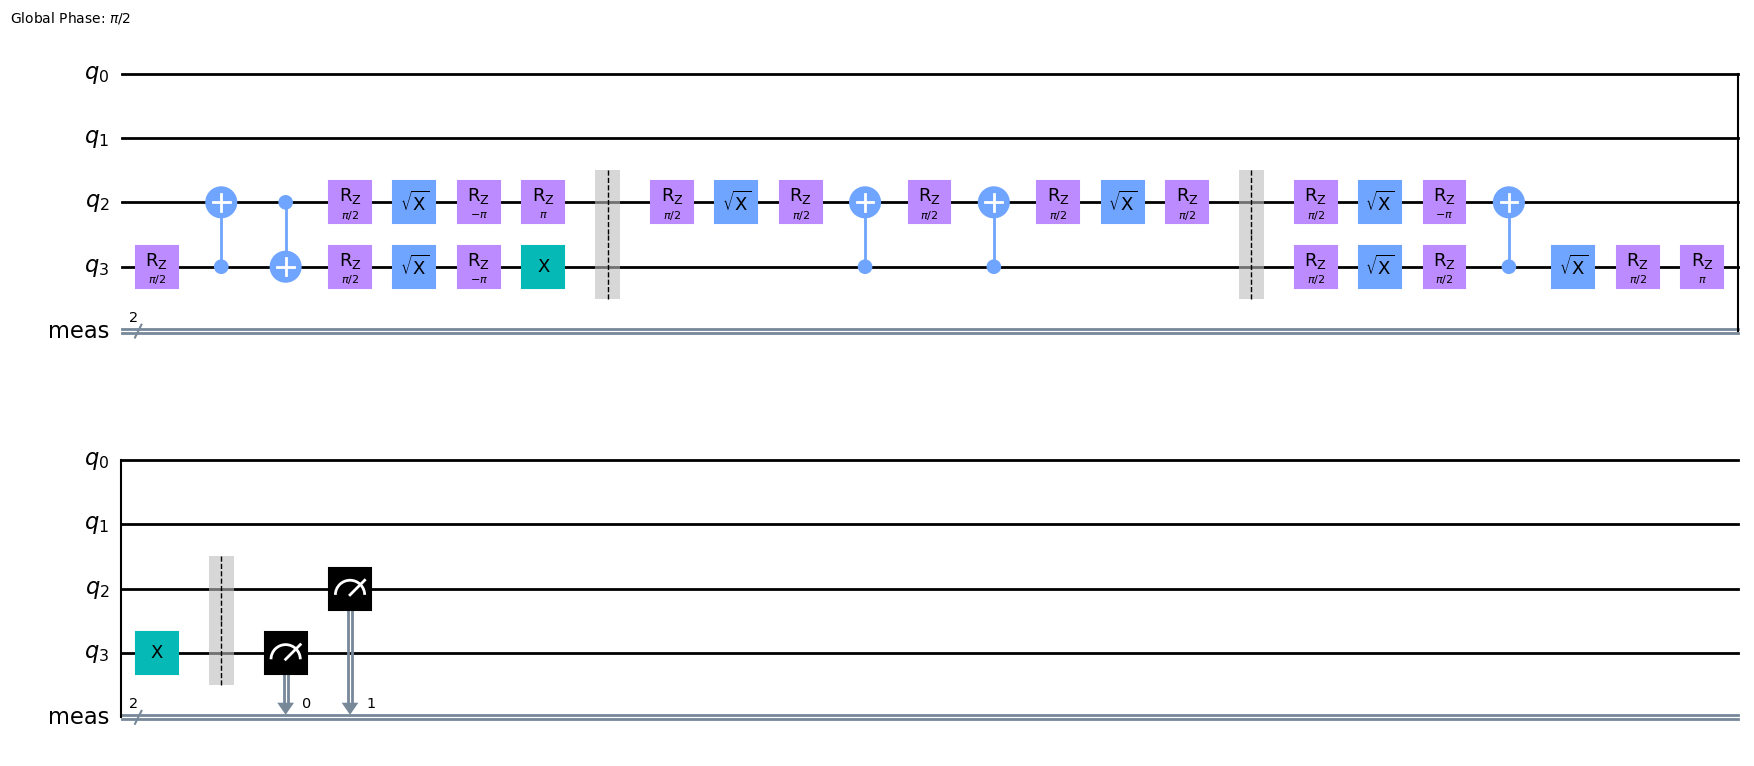

In [18]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')